# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fliajkde
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fliajkde
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.1.0+cu121


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
#model.cpu().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f0844c6a9e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

# Setting up input images and texts

We are going to feed example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


images_dir = '/content/drive/MyDrive/CS2002/New_Realism'
descriptions_csv = '/content/drive/MyDrive/CS2002/artemis_dataset_release_v0 - new_realism.csv'

# Load the textual descriptions from a CSV file into a dictionary
descriptions_df = pd.read_csv(descriptions_csv)
# painting: filename, emotion: description
descriptions = pd.Series(descriptions_df.emotion.values, index=descriptions_df.painting).to_dict()
#descriptions

In [ ]:
ARTEMIS_EMOTIONS = ['amusement',
 'awe',
 'contentment',
 'excitement',
 'anger',
 'disgust',
 'fear',
 'sadness',
 'something else']

emotions = ["A picture making me feel " + emotion for emotion in ARTEMIS_EMOTIONS]


In [ ]:
import matplotlib.pyplot as plt

original_images = []
processed_images = []
texts = []
plt.figure(figsize=(16,5))

# Retrieve the filenames and filter out non-image files and images without descriptions
image_filenames = [filename for filename in os.listdir(images_dir) if filename.endswith(".png") or filename.endswith(".jpg")]
image_filenames = [filename for filename in image_filenames if os.path.splitext(filename)[0] in descriptions]

for i, filename in enumerate(image_filenames):
    name = os.path.splitext(filename)[0]


    image = Image.open(os.path.join(images_dir, filename)).convert("RGB")

    original_images.append(image)
    processed_images.append(preprocess(image))
    texts.append(descriptions[name])




<Figure size 1600x500 with 0 Axes>

In [ ]:
len(original_images)

314

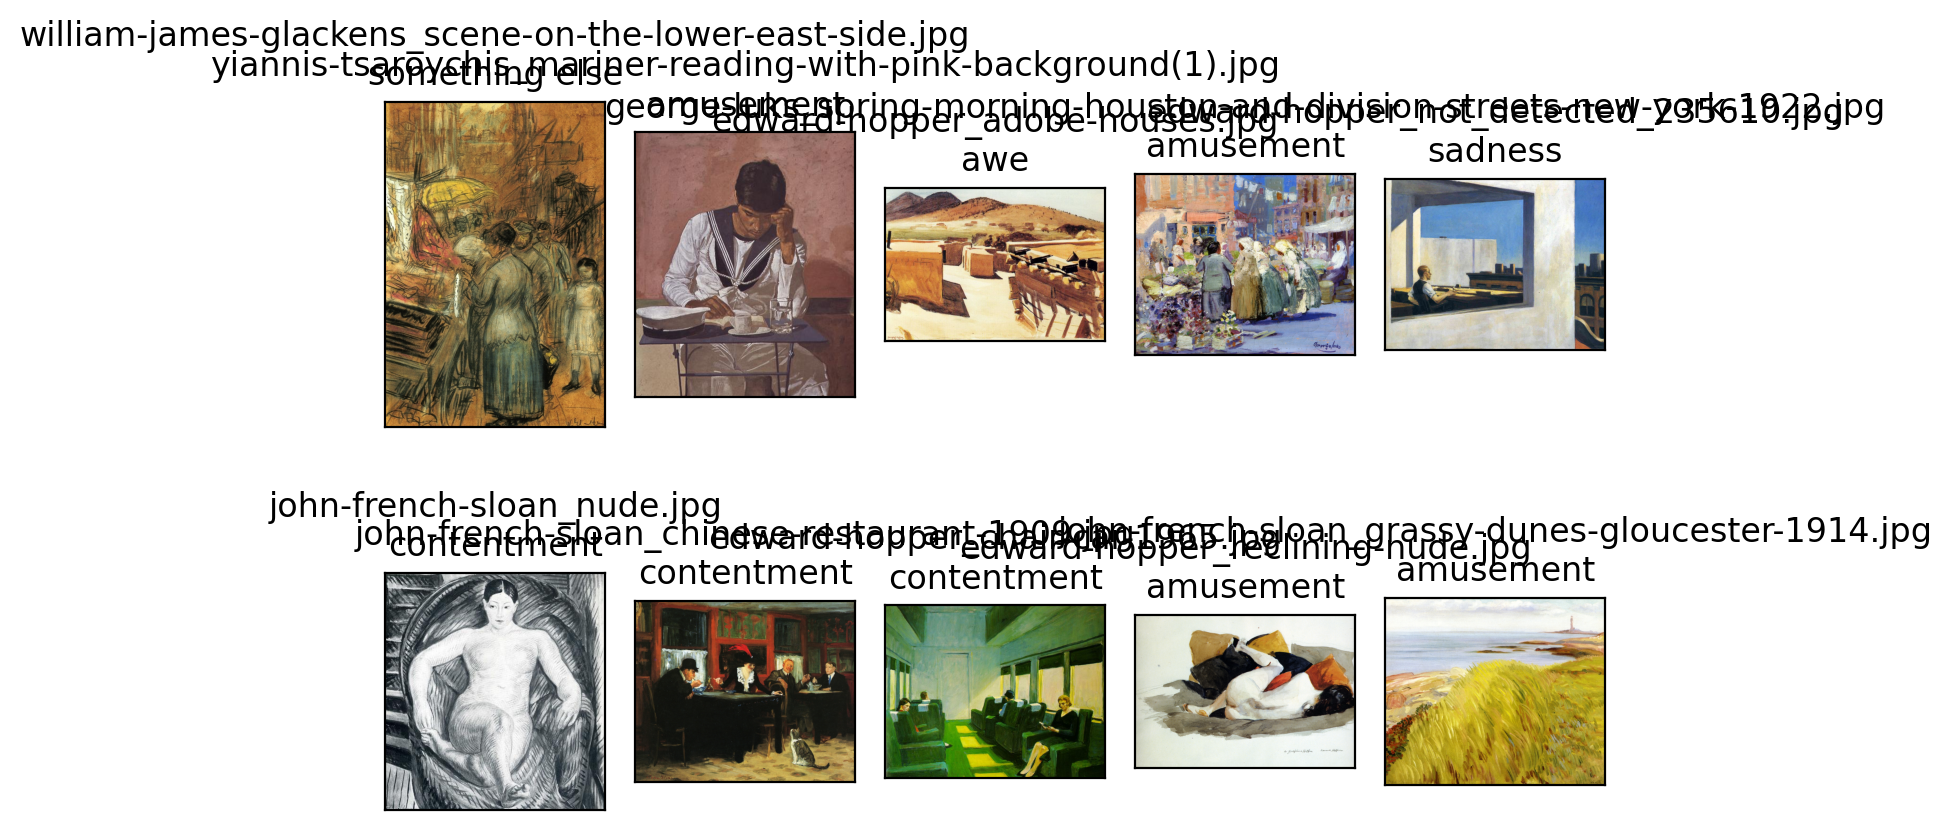

In [ ]:
for i, filename in enumerate(image_filenames[:10]):
    name = os.path.splitext(filename)[0]

    # Display the image with its filename and description
    plt.subplot(2, 5, i + 1)  # Adjust the subplot grid as 2 rows and 5 columns
    plt.imshow(original_images[i])
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
print(texts)
print(emotions)
len(texts)
len(emotions)

In [ ]:
# image_input = torch.tensor(np.stack(processed_images)).cpu()
# text_tokens = clip.tokenize(emotions).cpu()
image_input = torch.tensor(np.stack(processed_images)).cuda()
text_tokens = clip.tokenize(emotions).cuda()
print (image_input.shape)
print (text_tokens.shape)

torch.Size([314, 3, 224, 224])
torch.Size([9, 77])


In [ ]:
with torch.no_grad(): #Encoding
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
similarity.shape

(9, 314)

['amusement', 'awe', 'contentment', 'excitement', 'anger', 'disgust', 'fear', 'sadness', 'something else']
(9, 10)


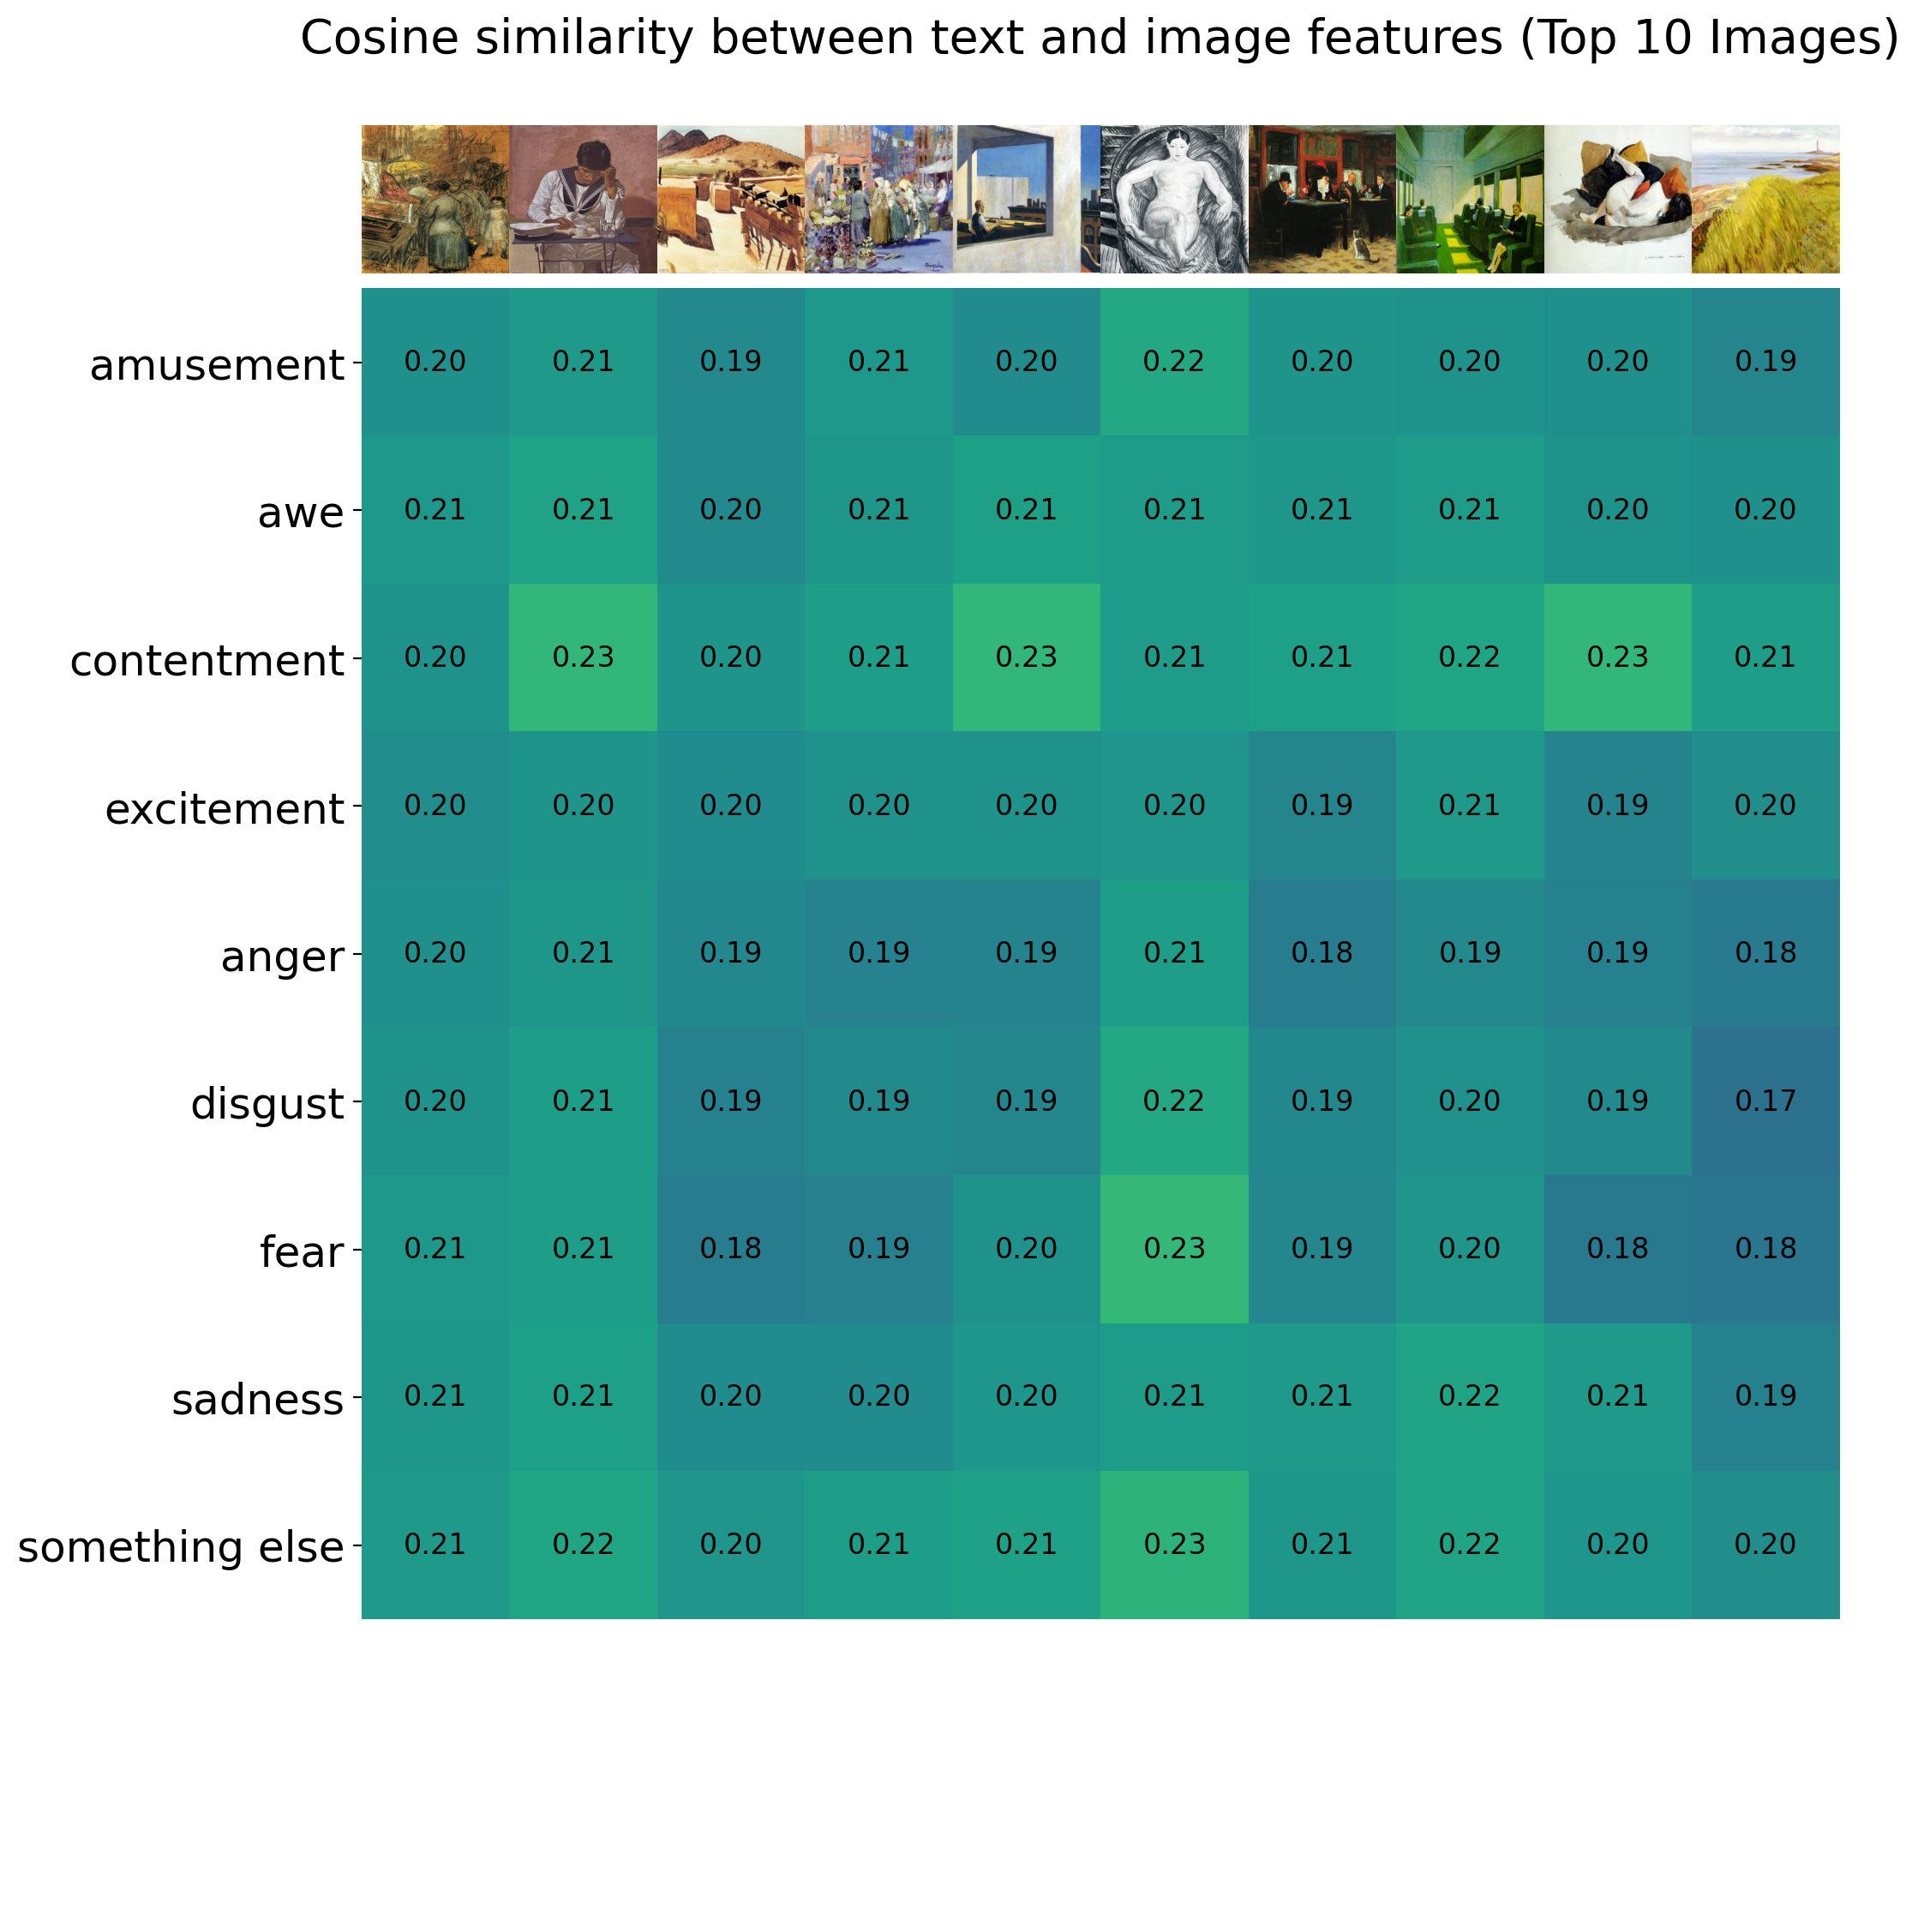

In [ ]:


# Limit to the first 10 images and emotions
count = 10
limited_texts = ARTEMIS_EMOTIONS
print (limited_texts)
limited_original_images = original_images[:count]
limited_similarity = similarity[:len(ARTEMIS_EMOTIONS), :count]
print (limited_similarity.shape)

plt.figure(figsize=(20, 14))
plt.imshow(limited_similarity, vmin=0.1, vmax=0.3)

plt.yticks(range(len(ARTEMIS_EMOTIONS)), limited_texts, fontsize=18)
plt.xticks([])


for i, image in enumerate(limited_original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Loop through the first 10 rows and columns to display text annotations for similarity scores
for x in range(limited_similarity.shape[1]):
    for y in range(limited_similarity.shape[0]):
        plt.text(x, y, f"{limited_similarity[y, x]:.2f}", ha="center", va="center", size=12)


for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features (Top 10 Images)", size=20)
plt.show()


# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
# text_descriptions = [f"an image evoking {label}" for label in descriptions_df.emotion]
# text_tokens = clip.tokenize(text_descriptions).cuda()
print(len(emotions))
print(len(text_tokens))
print(len(image_features))

9
9
314


In [ ]:
with torch.no_grad():
    text_features_z = model.encode_text(text_tokens).float()
    text_features_z /= text_features_z.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features_z.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
# new_images = []
# # Loop through the first 10 image filenames with descriptions
# for i, filename in enumerate(image_filenames):
#     name = os.path.splitext(filename)[0]

#     # Open the image file
#     ima = Image.open(os.path.join(images_dir, filename)).convert("RGB")
#     new_images.append(ima)
# len(new_images)
len(original_images)
for filename in image_filenames[:10]:
    print(filename)

william-james-glackens_scene-on-the-lower-east-side.jpg
yiannis-tsaroychis_mariner-reading-with-pink-background(1).jpg
edward-hopper_adobe-houses.jpg
george-luks_spring-morning-houston-and-division-streets-new-york-1922.jpg
edward-hopper_not_detected_235610.jpg
john-french-sloan_nude.jpg
john-french-sloan_chinese-restaurant-1909.jpg
edward-hopper_chair-car-1965.jpg
edward-hopper_reclining-nude.jpg
john-french-sloan_grassy-dunes-gloucester-1914.jpg


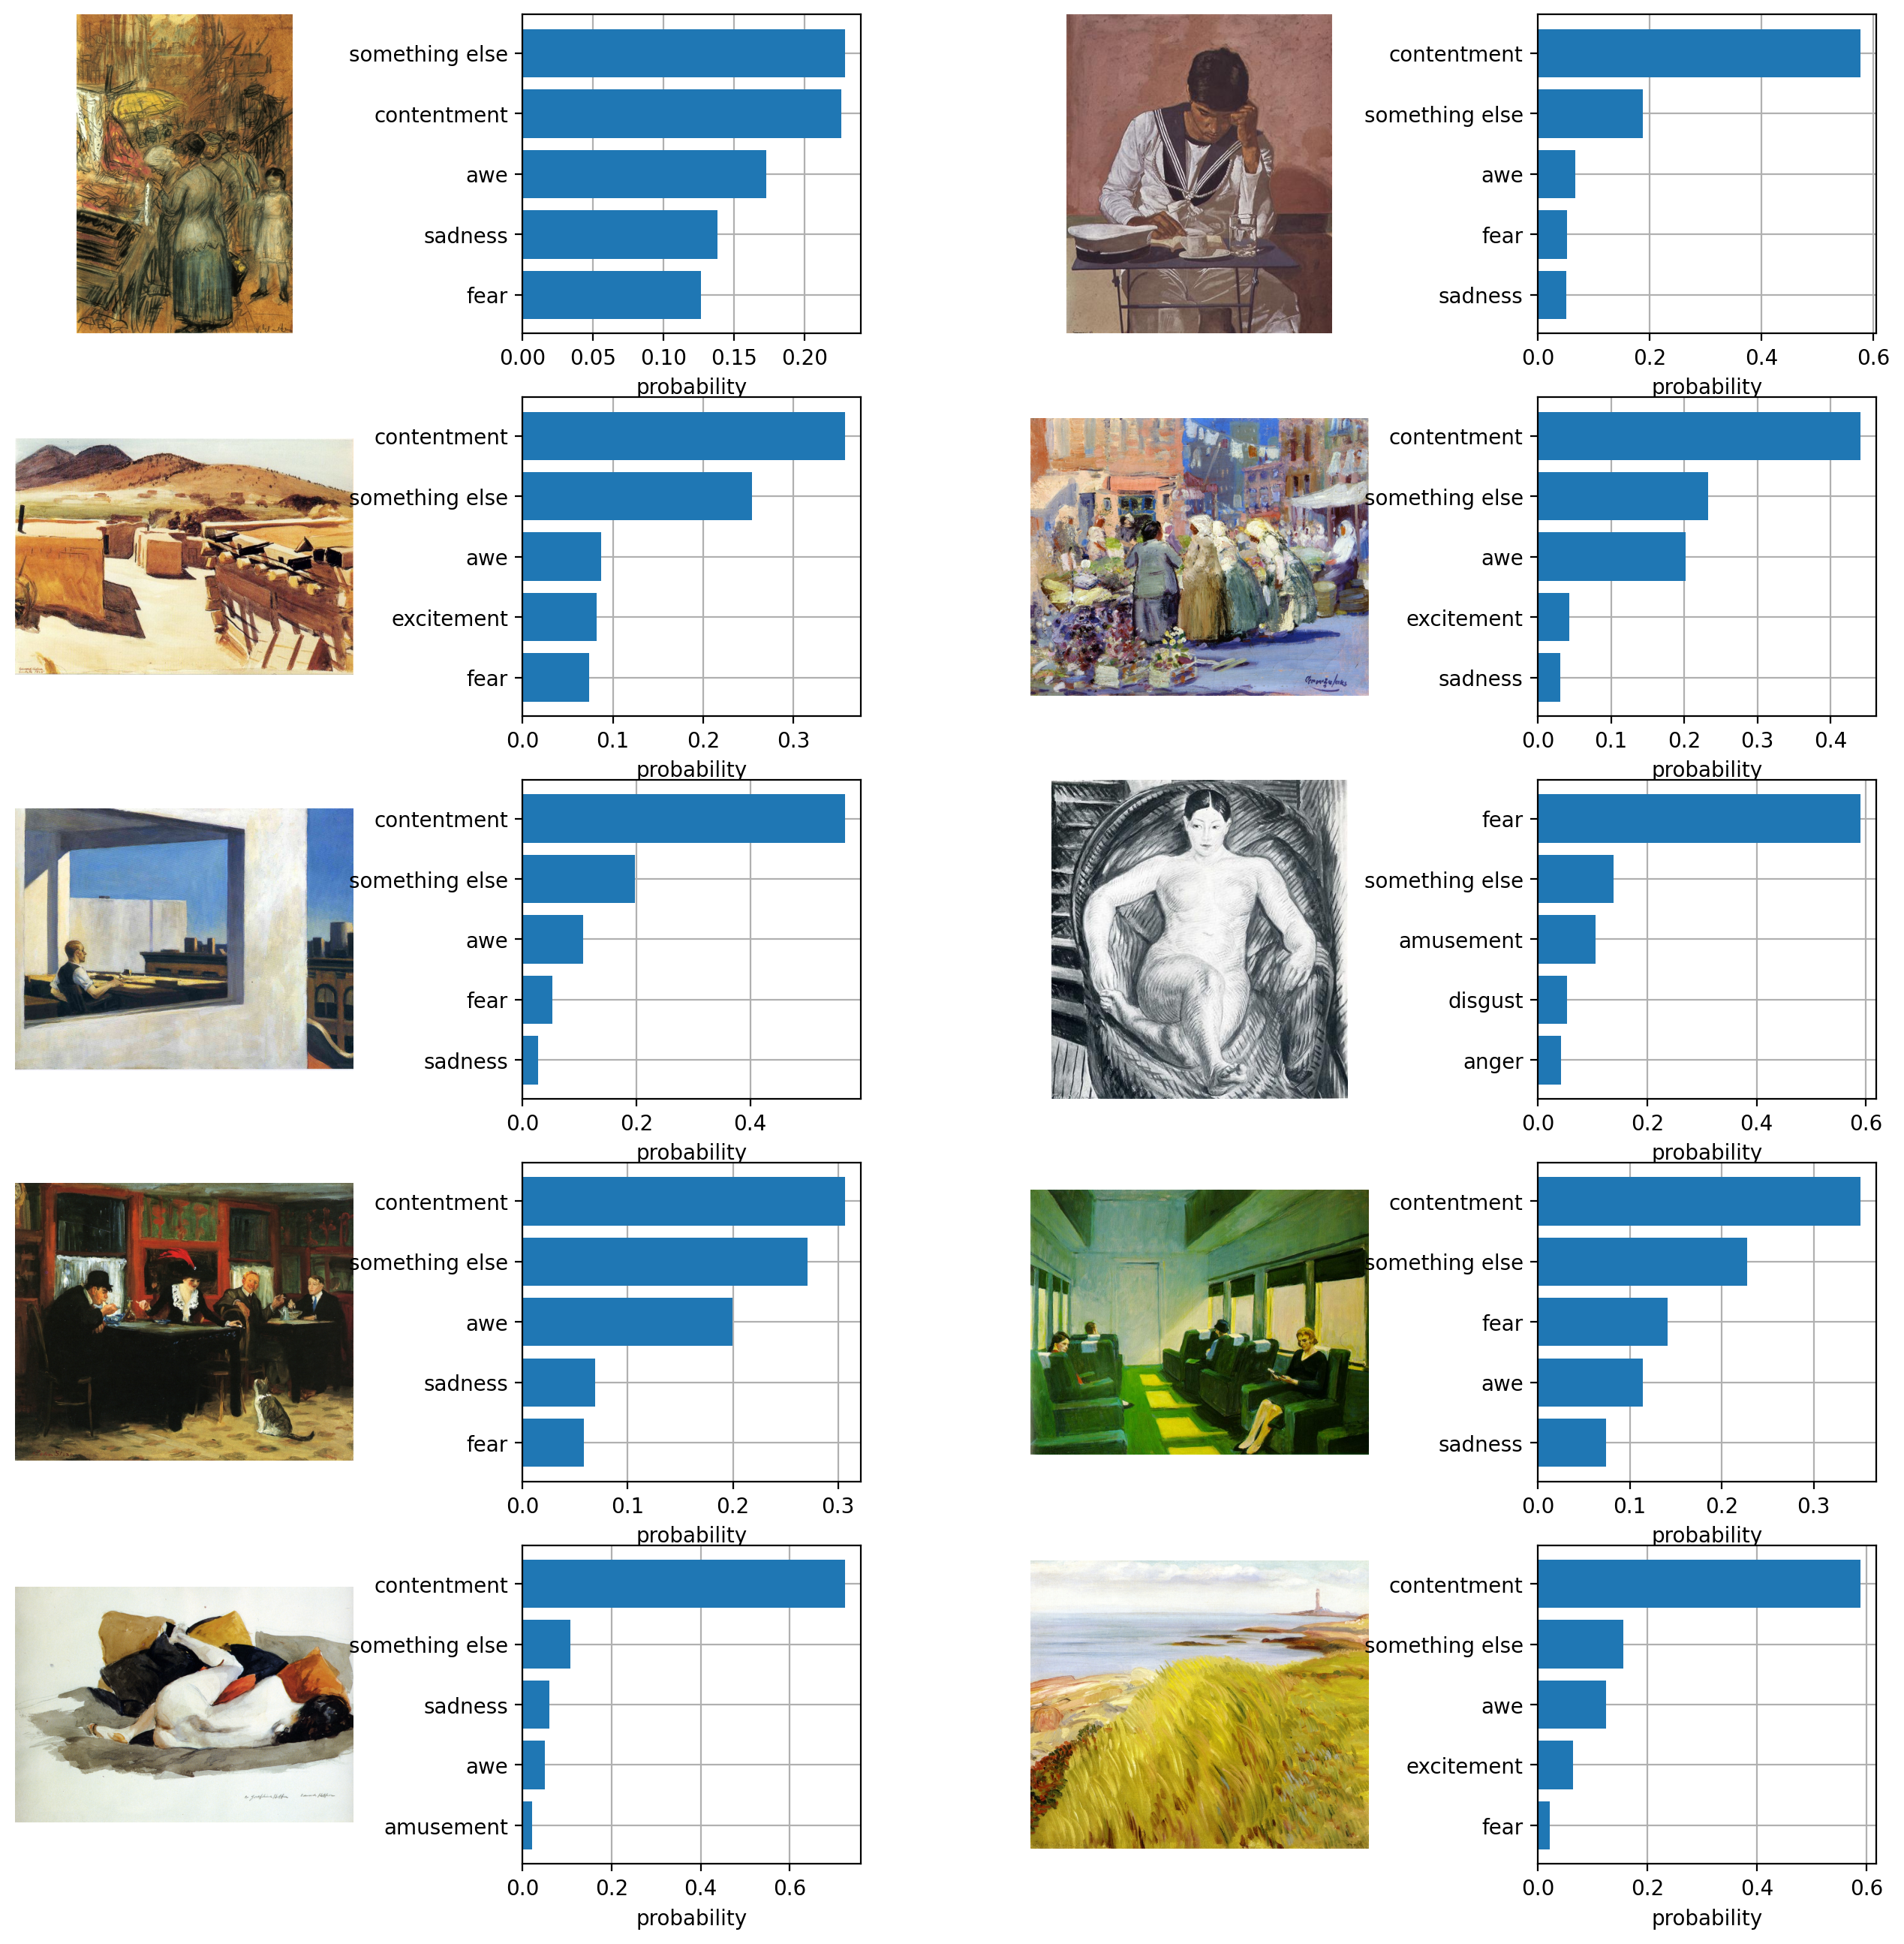

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images[:10]):
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [ARTEMIS_EMOTIONS[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()


In [ ]:
# 'text_probs' -> array of probabilities by the model
# descriptions_df -> DataFrame with 'painting', 'emotion', and 'repetition' columns

# Create a matrix of zeros with dimensions: number of images x number of emotions
labels_matrix = np.zeros((len(descriptions_df['painting'].unique()), len(ARTEMIS_EMOTIONS)))
print(labels_matrix.shape)

(314, 9)


In [ ]:
# Matrix with repetition counts from the DataFrame

for i, painting in enumerate(descriptions_df['painting'].unique()):
    painting_df = descriptions_df[descriptions_df['painting'] == painting]
    if i == 4:
      print(len(painting_df))
      print(painting_df)
    for _, row in painting_df.iterrows():
        emotion_index = ARTEMIS_EMOTIONS.index(row['emotion'])
        labels_matrix[i, emotion_index] += 1
print(ARTEMIS_EMOTIONS)
print(labels_matrix.shape)
print(labels_matrix[:10])


5
       art_style                        painting      emotion  \
5    New_Realism  edward-hopper_american-village    amusement   
12   New_Realism  edward-hopper_american-village  contentment   
196  New_Realism  edward-hopper_american-village          awe   
197  New_Realism  edward-hopper_american-village         fear   
205  New_Realism  edward-hopper_american-village  contentment   

                                             utterance  repetition  
5    This reminds me of snow days when I was in sch...           5  
12   a sense of peace.  resembles the small town wh...           5  
196  so beautiful the view and experiencing how lif...           5  
197  Traveling on ice and snow is a terrifying feel...           5  
205             this is a very calm and relaxing scene           5  
['amusement', 'awe', 'contentment', 'excitement', 'anger', 'disgust', 'fear', 'sadness', 'something else']
(314, 9)
[[ 0.  0.  3.  1.  0.  0.  0.  0.  1.]
 [ 0.  2.  4.  0.  0.  0.  1.  0.  0.]

In [ ]:
print(len(descriptions_df['painting'].unique()))

314


In [ ]:
class MockDataset:
    def __init__(self, labels_matrix):
        # Convert pandas DataFrame/Series to numpy array if necessary
        self.labels = labels_matrix.values if isinstance(labels_matrix, pd.DataFrame) or isinstance(labels_matrix, pd.Series) else labels_matrix
mock_dataset = MockDataset(labels_matrix)
print(mock_dataset.labels[:10])

[[ 0.  0.  3.  1.  0.  0.  0.  0.  1.]
 [ 0.  2.  4.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  3.  0.  0.  0.  0.  1.  1.]
 [21.  7.  8.  7.  0.  0.  1.  0.  3.]
 [ 1.  1.  2.  0.  0.  0.  1.  0.  0.]
 [ 1.  1.  3.  2.  0.  0.  0.  0.  0.]
 [ 1.  2.  0.  1.  0.  1.  0.  0.  0.]
 [ 2.  0.  0.  3.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  2.  0.  0.  0.  2.  0.]
 [ 0.  1.  0.  3.  0.  0.  0.  0.  1.]]


In [ ]:
## helper function.
## to evaluate how well the model does according to the class that it finds most likely
## note it only concerns the predictions on examples (images) with a single -unique maximizer- emotion

# def evaluate_argmax_prediction(dataset, guesses):
#     labels = dataset.labels
#     # The original code assumes 'labels' is a pandas DataFrame
#     unique_max = (labels == labels.max(1, keepdims=True)).sum(1) == 1
#     umax_ids = np.where(unique_max)[0]
#     gt_max = np.argmax(labels[unique_max], 1)
#     max_pred = np.argmax(guesses[umax_ids], 1)

#     accuracy = (gt_max == max_pred).mean()
#     return accuracy, gt_max,max_pred

import random
from collections import Counter
def evaluate_argmax_prediction(dataset, guesses):
    labels = dataset.labels


    accuracy_list = []
    gt_max_list = []
    max_pred_list = []
    t_labels = []
    p_labels = []

    for idx in range(len(labels)):
        label_row = labels[idx]
        guess_row = guesses[idx]

        # Check if there's a unique maximizer
        # print (label_row)
        # print (label_row == label_row.max())
        # print ((label_row == label_row.max()).sum())

        unique_max = (label_row == label_row.max()).sum() == 1

        if unique_max:
            gt_max = np.argmax(label_row)
        else:
            # If no unique maximizer exists, choose randomly among non-zero emotions
            non_zero_emotions = np.where(label_row >= 1)[0]
            if len(non_zero_emotions) > 0:
                gt_max = random.choice(non_zero_emotions)
            else:
                continue  # Skip if all counts are zero

        max_pred = np.argmax(guess_row)
        t_labels.append(gt_max)
        p_labels.append(max_pred)
        # Calculate accuracy for this instance
        accuracy = int(gt_max == max_pred)
        accuracy_list.append(accuracy)

        # ground truth and model prediction
        gt_max_list.append(gt_max)
        max_pred_list.append(max_pred)
    print ("true label dist")
    dist = Counter(t_labels)
    for key in dist:
      print (key, dist[key], (dist[key]*1.0/len(t_labels)))
    print ("-----------------------------")
    print ("pred label dist")
    dist = Counter(p_labels)
    for key in dist:
      print (key, dist[key], (dist[key]*1.0/len(p_labels)))
    exit()

    # Overall accuracy
    overall_accuracy = np.mean(accuracy_list) if accuracy_list else 0

    return overall_accuracy, np.array(gt_max_list), np.array(max_pred_list)




In [ ]:

# move the tensor to the CPU, then convert it to a numpy array
text_probs_cpu = text_probs.cpu().numpy()
# print (text_probs)
accuracy,gt_max,max_pred = evaluate_argmax_prediction(mock_dataset, text_probs_cpu)
print(f"Accuracy for images with a unique maximizer emotion: {accuracy:.2f}")

# # Recreate 'unique_max' filter based on the full labels dataset
# labels = mock_dataset.labels
# unique_max = (labels == labels.max(1, keepdims=True)).sum(1) == 1
# filtered_top_labels = top_labels[unique_max]

true label dist
2 110 0.3503184713375796
0 29 0.09235668789808917
1 36 0.11464968152866242
3 25 0.07961783439490445
7 51 0.1624203821656051
8 24 0.07643312101910828
5 11 0.03503184713375796
6 28 0.08917197452229299
-----------------------------
pred label dist
8 87 0.2770700636942675
2 160 0.5095541401273885
6 41 0.1305732484076433
0 4 0.012738853503184714
1 19 0.06050955414012739
4 2 0.006369426751592357
7 1 0.0031847133757961785
Accuracy for images with a unique maximizer emotion: 0.20


In [ ]:
print(len(text_probs_cpu))
print(len(gt_max))
print(len(max_pred))

314
314
314
